# MNIST with Keras

## Import

In [80]:
!pip install matplotlib

Looking in indexes: https://artifactory.int.datarobot.com/artifactory/api/pypi/python-all/simple
     |████████████████████████████████| 12.4 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 4.0 MB/s eta 0:00:011


In [102]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple

Shape = namedtuple('Size', ['rows', 'columns'])
Hyperparameter = namedtuple('Hyperparameter', ['batch_size', 'number_classes', 'epochs', 'target_shape', 'window_size', 'pool_size'])


%matplotlib inline

In [103]:
def reshape(x: np.ndarray, shape=None) -> np.ndarray:
    """
    Each image is 1-dimensional array.
    This function reshapes each image to 2-dimensional matrix,
        where its size is defined with `shape`.
        
    Parameters
    ----------
    x: Data
    shape: Target shape of each image. If not specified, it will reshape to Shape(28, 28)
    
    Returns
    -------
    np.ndarray
    """
    if shape is None:
        shape = Shape(28, 28)
    
    reshaped_x = x.reshape(x.shape[0], shape.rows, shape.columns, 1)
    return reshaped_x

In [104]:
def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalize data:
        - convert all values in a range within 0 and 1
        - cast all values to float
        
    Parameters
    ----------
    x: Data for training
    
    Returns
    -------
    np.ndarray
    """
    return x.astype('float32') / 255

In [105]:
def encode_into_onehot(y: np.ndarray, number_classes: int):
    """
    Convert an array of answers into onehot encoded matrix.
    
    Parameters
    ----------
    y: target array that will be convert to one hot encoded matrix
    number_classes: total number of classes
    
    Returns
    -------
    np.ndarray, matrix with shape of (number_classes x number_classes)
    """

    if number_classes < 1:
        raise ValueError(f'Number of classes must be greater than 1, given {number_classes}')

    one_hot_encoded_y = keras.utils.to_categorical(y, number_classes)
    return one_hot_encoded_y

In [106]:
def build_keras_model(window_size: Shape, pool_size: Shape, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = Sequential()
    # 32 - number of filters (kernels) that neural network is going to be learnt with
    # each kernel has kernel size, each kernel has certain features it gathered while learning
    # for first convolution, it's required to point input shape to start off
    # in addition, it's good to use ReLu activation function.
    # it's non-linear and allows network to converge faster.
    model.add(Conv2D(32,
                     kernel_size=tuple(window_size),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, 
                     kernel_size=tuple(window_size), 
                     activation='relu'))

    # based on kernels
    # max pooling takes the max. value of matrix with size of given pool.
    # it's a sliding window for kernels
    # pooling reduces variance and speed up computation by shrinking matrices.
    # there is one more pooling algorithm: average.
    # maxpooling works better because it extracts important (max.) features (the brightest ones), 
    # and does not allow activated signals to fade out
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # after extracting important feature
    # it's highly required and recommended to use dropout
    # to avoid overfitting on training data.
    # Dropout disables each neuron with a probability of 25%.
    model.add(Dropout(0.25))
    
    # converts multidimensional matrix into 1-dimensional matrix (vector).
    # it's an input signals to the furthur Dense nets
    model.add(Flatten())
    
    # it's a simple dense net with 128 units
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    
    # in case of multiclasses, softmax algorithm is used.
    # a known logistic function (binary classification) is a special case of softmax.
    model.add(Dense(
        units=number_classes,
        activation='softmax'))

    # in alternative to binary crossentropy, it's used categorical one to calculate loss
    # there are a bunch of optimizers: RMSprop, Adadelta, Adamax, Adam, etc.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    return model

In [107]:
def visualize_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy of the model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def visualize_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss of the model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [108]:
hyperparameter = Hyperparameter(
    batch_size=128,
    number_classes=10, # there are only 10 digits
    epochs=12,
    target_shape=Shape(rows=28, columns=28),
    window_size=Shape(rows=3, columns=3),
    pool_size=Shape(rows=2, columns=2),
)

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain = reshape(x=xtrain, shape=hyperparameter.target_shape)
xtest = reshape(x=xtest, shape=hyperparameter.target_shape)
xtrain = normalize(xtrain)
xtest = normalize(xtest)

ytrain = encode_into_onehot(ytrain, number_classes=hyperparameter.number_classes)
ytest = encode_into_onehot(ytest, number_classes=hyperparameter.number_classes)

print('Xtrain shape: ', xtrain.shape)
print('Ytrain shape: ', ytrain.shape)
print('Xtest shape: ', xtest.shape)
print('Ytest shape: ', ytest.shape)

model = build_keras_model(
    window_size=hyperparameter.window_size,
    pool_size=hyperparameter.pool_size,
    number_classes=hyperparameter.number_classes,
)

history = model.fit(xtrain, ytrain,
      batch_size=hyperparameter.batch_size,
      epochs=hyperparameter.epochs,
      validation_data=(xtest, ytest),
      verbose=1,
)

Xtrain shape:  (60000, 28, 28, 1)
Ytrain shape:  (60000, 10)
Xtest shape:  (10000, 28, 28, 1)
Ytest shape:  (10000, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 49s 815us/step - loss: 0.2749 - accuracy: 0.9151 - val_loss: 0.0652 - val_accuracy: 0.9789
Epoch 2/12
60000/60000 [==============================] - 49s 815us/step - loss: 0.0898 - accuracy: 0.9732 - val_loss: 0.0403 - val_accuracy: 0.9862
Epoch 3/12
60000/60000 [==============================] - 49s 818us/step - loss: 0.0662 - accuracy: 0.9804 - val_loss: 0.0345 - val_accuracy: 0.9891
Epoch 4/12
60000/60000 [==============================] - 50s 839us/step - loss: 0.0550 - accuracy: 0.9832 - val_loss: 0.0340 - val_accuracy: 0.9891
Epoch 5/12
60000/60000 [==============================] - 49s 823us/step - loss: 0.0480 - accuracy: 0.9850 - val_loss: 0.0319 - val_accuracy: 0.9897
Epoch 6/12
60000/60000 [==============================] - 49s 809us/step - loss: 0.04

Test loss: 2.6355050009788363
Test accuracy: 99.22000169754028


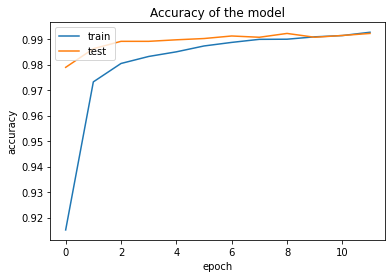

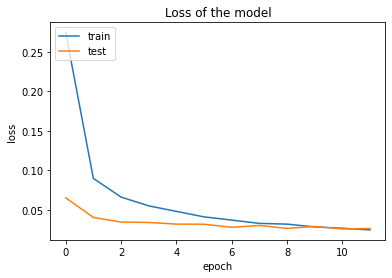

In [109]:
loss, accuracy = model.evaluate(xtest, ytest, verbose=0)
print('Test loss:', loss * 100)
print('Test accuracy:', accuracy * 100)

visualize_accuracy(history)
visualize_loss(history)